# Spam classifier

 Importing necessary libraries



In [ ]:
!pip install colabcode
!pip install fastapi

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_extraction, model_selection, naive_bayes, metrics
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


# Loading the data

In [ ]:
msgs = pd.read_csv('data/spam.csv',encoding='latin-1')
msgs.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The last 3 columns do not contain any required information and hence can be removed

In [ ]:
msgs.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
msgs.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


It would be convenient to rename column v1 as label as it indicates whether the messages are ham/spam and column v2 as messages

In [ ]:
msgs.rename(columns = {'v1': 'label', 'v2': 'message'}, inplace = True)
msgs.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory data analysis

In [ ]:
msgs.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#Visualizing data


*  WordCloud library is used to see the most repeated words

Word cloud for spam messages

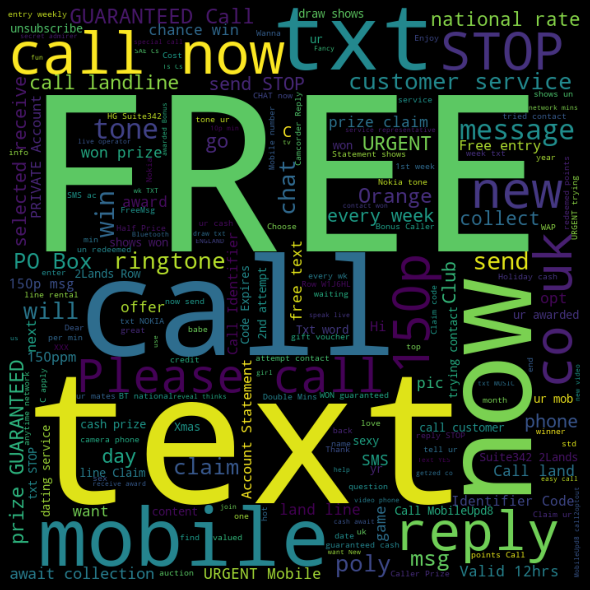

In [ ]:
spam_words = ' '.join(list(msgs[msgs['label'] == 'spam']['message']))
spam_wc = WordCloud(width = 700,height = 700).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Word cloud for ham messages

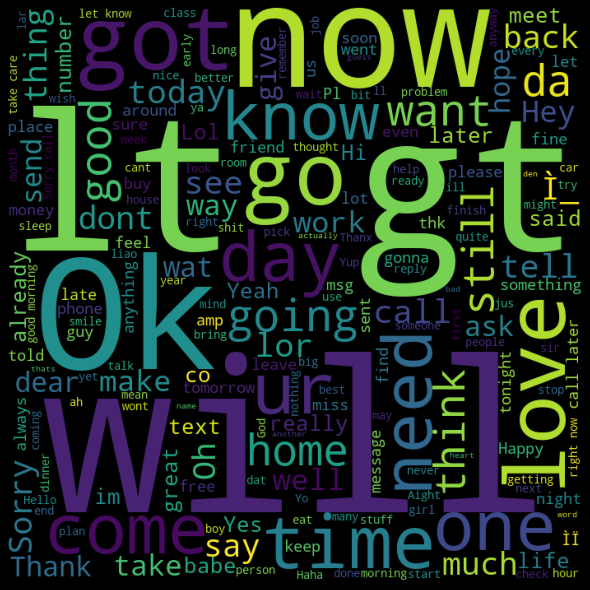

In [ ]:
ham_words = ' '.join(list(msgs[msgs['label'] == 'ham']['message']))
ham_wc = WordCloud(width = 700,height = 700).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Data Preprocessing


*   Stemming is done to obtain root words
*   Extra symbols are removed
*   messages are converted to lower case
*   Stop words are removed



In [ ]:
le=LabelEncoder() 
y=msgs.iloc[:,0].values
msgs['category']=le.fit_transform(y)

ps = PorterStemmer()
corpus = []
for i in range(0, len(msgs)):
    review = re.sub('[^a-zA-Z]', ' ', msgs['message'][i])
    review = review.lower() 
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)


Creating Bag of words


*   converting the text into vectors using Countvectorizer


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500)
x = cv.fit_transform(corpus).toarray()
y = msgs.category
y = y.astype('int') 

Bar plot

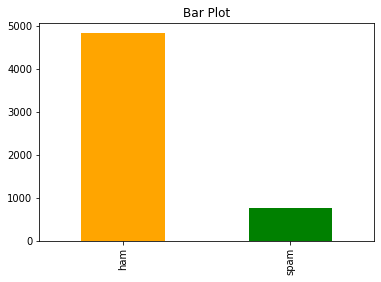

In [ ]:
count=pd.value_counts(msgs['label'], sort= True)
count.plot(kind = 'bar',color = ["orange","green"])
plt.title('Bar Plot')
plt.show();

The dataset is imbalanced and this needs to be balanced as the model would predict all the mails as ham(since more number of ham messages are present) and hence would be biased.


*   We use SMOTE technique to balance the data
*   Synthetic Minority Over-sampling Technique(SMOTE) is a technique that generates new observations by interposing between observations in the existing data. 



In [ ]:
oversample = SMOTE()
x_res,y_res = oversample.fit_resample(x, y)

The resampled dataset is as follows:

In [ ]:
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 4825, 1: 4825})


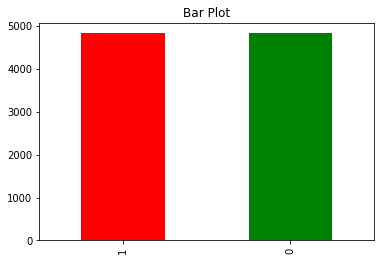

In [ ]:
count=pd.value_counts(y_res, sort= True)
count.plot(kind = 'bar',color = ["red","green"])
plt.title('Bar Plot')
plt.show();

# Performing Train and Test data split


*   Data is split in the ratio of 80:20 for Train:Test respectively 
*   Selection of this data is done randomly


In [ ]:
x_train, x_test , y_train, y_test = train_test_split(x_res,y_res,test_size=0.20, random_state=42)


*   x_train, y_train – training inputs and labels – Training Set
*   x_test, y_test – testing inputs and labels – Testing Set




# Training the model

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import pickle
nb = MultinomialNB()
nb.fit(x_train, y_train)
pkl_filepath = "model_folder/model_nb.pkl"  
with open(pkl_filepath, 'wb') as file:  
    pickle.dump(nb, file)
y_pred = nb.predict(x_test)

Confusion matrix and Accuracy score is displayed





In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",cm)
print("\nAccuracy Score:")
accuracy_score(y_test, y_pred)

Confusion Matrix:
 [[961  24]
 [ 29 916]]

Accuracy Score:


0.9725388601036269

# Plotting a graph out of Confusion matrix

Text(33.0, 0.5, 'Actual')

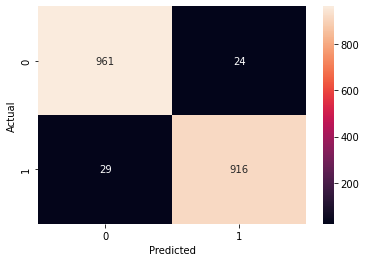

In [ ]:
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Prediction
A spam message

In [ ]:
test = ["Win cash worth Rs.1000/-"]
test_vec = cv.transform(test)
result = nb.predict(test_vec)
print(le.inverse_transform(result))

['spam']


A ham message

In [ ]:
test1 = ["Get well soon"]
test_vec = cv.transform(test1)
result = nb.predict(test_vec)
print(le.inverse_transform(result))

['ham']


# Fast-API


In [ ]:
from fastapi import FastAPI, Request, HTTPException
from fastapi.responses import UJSONResponse
from pydantic import BaseModel
from typing import Optional
import sys, os
import yaml


app = FastAPI()

class SpamText(BaseModel):
    text : str

@app.on_event("startup")
def load_model():
    global nb
    nb = pickle.load(open("model_folder/model_nb.pkl", "rb"))

@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}

@app.post('/predict')
def classify_message(data: SpamText):
  testlist = [data.text]
  test_vec = cv.transform(testlist)
  result = nb.predict(test_vec)
  verdict = le.inverse_transform(result)
  print(verdict)
  return verdict[0]

#Running the model in localhost

In [ ]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [ ]:
server.run_app(app=app)

Public URL: NgrokTunnel: "https://c095-35-201-217-98.ngrok.io" -> "http://localhost:10000"


INFO:     Started server process [434]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)
